In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns

from sklearn.metrics import mean_squared_error as mse_score

import mxnet as mx
import mxnet.gluon as gluon
import mxnet.gluon.nn as nn

from model import LSTMExogModel
import utils
import train
import data

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
dataset = data.GenSequenceDataset(50, 50, spacing=20)

<IPython.core.display.Javascript object>


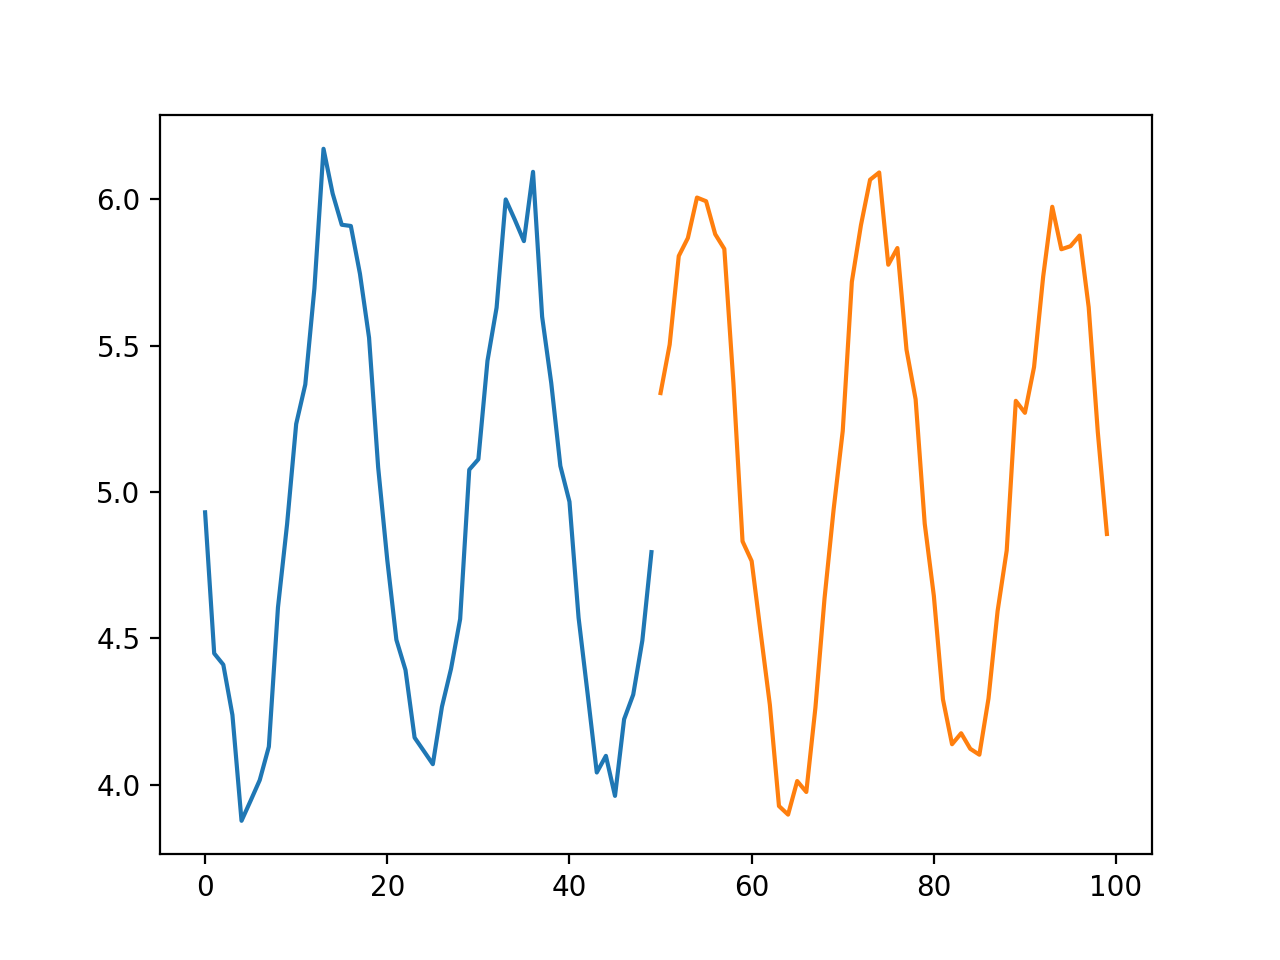

In [10]:
inp, exog, outp = dataset[0]
fig, ax = plt.subplots()
ax.plot(np.arange(inp.shape[0]), inp.asnumpy())
ax.plot(np.arange(inp.shape[0], inp.shape[0] + outp.shape[0]), outp.asnumpy())

In [5]:
batch_size = 32
ctx = mx.cpu()
loader = gluon.data.DataLoader(dataset, batch_size=batch_size, last_batch='discard', shuffle=True)

In [12]:
# a, b = next(iter(loader))

In [424]:
class CutLeft(gluon.Block):
    def __init__(self, cut_size):
        super(CutLeft, self).__init__()
        self.cut_size = cut_size
        
    def forward(self, x):
        return x[:, :, :-self.cut_size]
        
class TemporalBlock(gluon.Block):

    def __init__(self, k, d, out_channels, in_channels=1, dropout=0.4):
        super(TemporalBlock, self).__init__()
        self.in_channels = in_channels
        self.kernel_size = k
        self.dilation = d
        self.out_channels = out_channels
        
        self.net = gluon.nn.Sequential()
        self.conv1 = gluon.nn.Conv1D(out_channels, k, in_channels=in_channels, dilation=d, padding=d * (k - 1))
        self.cut1 = CutLeft(d * (k - 1))
        self.bn1 = gluon.nn.BatchNorm()
        self.relu1 = gluon.nn.Activation('relu')
        self.dropout1 = gluon.nn.Dropout(dropout)
        self.conv2 = gluon.nn.Conv1D(out_channels, k, in_channels=out_channels, dilation=d, padding=d * (k - 1))
        self.cut2 = CutLeft(d * (k - 1))
        self.bn2 = gluon.nn.BatchNorm()
        self.relu2 = gluon.nn.Activation('relu')
        self.dropout2 = gluon.nn.Dropout(dropout)
        layers = [self.conv1, self.cut1, self.bn1, self.relu1, self.dropout1, self.conv2, self.cut2,
                 self.bn2, self.relu2, self.dropout2]
        for layer in layers:
            self.net.add(layer)
        self.relu = nn.Activation('relu')
        self.downsample = nn.Conv1D(out_channels, 1) if in_channels != out_channels else None
        
    def forward(self, inputs):
        out = self.net(inputs)
        res = inputs if self.downsample is None else self.downsample(inputs)
        return self.relu(out + res)

class TemporalConvNet(gluon.Block):

    def __init__(self, out_channels, in_channels, dropout=0.0, kernel_size=2):
        super(TemporalConvNet, self).__init__()
        self.net = nn.Sequential()
        num_levels = len(out_channels)
        for i in range(num_levels):
            dilation = 2 ** i
            in_channels = in_channels if i == 0 else out_channels[i-1]
            _out_channels = out_channels[i]
            self.net.add(TemporalBlock(kernel_size, dilation, _out_channels, in_channels=in_channels,
                                     dropout=dropout))
        
    def forward(self, inputs):
        return self.net(inputs)

class TCN(gluon.Block):

    def __init__(self, channel_list, in_channels, input_seq_len, output_dim):
        super(TCN, self).__init__()
        self.input_seq_len = input_seq_len
        self.output_dim = output_dim
        self.tcn = TemporalConvNet(channel_list, in_channels=in_channels)
        self.dense = gluon.nn.Dense(output_dim)
        
    def forward(self, inputs, exog=None):
        tcn_out = self.tcn.forward(inputs)
        last_pred = tcn_out[:, :, self.input_seq_len - 1]
        combined = mx.nd.concat(last_pred, exog, dim=1)
        out = self.dense(combined)
        return out

In [455]:
batch_size = 64
input_seq_len = 100  # experiment with this number!!
output_seq_len = 1
num_layers = 1
feature_dim = 1
learning_rate = 0.001
channel_list = [10]

tcn = TCN2(channel_list, feature_dim, input_seq_len, output_seq_len)

# collect all NDArrays associated with each layer and initialize them
tcn.collect_params().initialize(mx.init.Xavier(), ctx=mx.cpu())

loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(tcn.collect_params(), 'adam', {'learning_rate': learning_rate})

datasets = {'train': data.GenSequenceFullDataset(input_seq_len, output_seq_len, return_sequences=False, spacing=15, lam=0.3),
            'valid': data.GenSequenceFullDataset(input_seq_len, output_seq_len, return_sequences=False, spacing=15, lam=0.3)}
loaders = {'train': gluon.data.DataLoader(datasets['train'], batch_size=batch_size, last_batch='discard'),
           'valid': gluon.data.DataLoader(datasets['valid'], batch_size=batch_size, last_batch='discard')}

train.train_epochs_tcn2(tcn, loaders, loss, trainer, num_epochs=20, log_interval=5)

[Epoch 5] train loss = 0.091
[Epoch 5] valid loss = 0.083
[Epoch 10] train loss = 0.064
[Epoch 10] valid loss = 0.068
[Epoch 15] train loss = 0.064
[Epoch 15] valid loss = 0.057
[Epoch 20] train loss = 0.048
[Epoch 20] valid loss = 0.049


In [490]:
trainer = gluon.Trainer(tcn.collect_params(), 'adam', {'learning_rate': 0.001})
train.train_epochs_tcn2(tcn, loaders, loss, trainer, num_epochs=20, log_interval=5)

0.223674
0.222503
0.225509
0.230223
[Epoch 5] train loss = 0.014
[Epoch 5] valid loss = 0.015
0.231445
0.235413
0.237415
0.239842
0.241451
[Epoch 10] train loss = 0.014
[Epoch 10] valid loss = 0.012
0.24338
0.245675
0.24913
0.248967
0.251262
[Epoch 15] train loss = 0.015
[Epoch 15] valid loss = 0.013
0.253643
0.256484
0.258145
0.260546
0.262013
[Epoch 20] train loss = 0.016
[Epoch 20] valid loss = 0.014
0.264485


In [526]:
pred_steps = 300
pred_ds = data.GenSequenceFullDataset(input_seq_len, pred_steps, spacing=15, lam=0.3)
loader = gluon.data.DataLoader(pred_ds, batch_size=batch_size, last_batch='discard')
a, b, c = next(iter(loader))

In [527]:
predict_input = a
exog = b
predict_seq_len = pred_steps
out_dim = 1

In [528]:
# w = tcn.dense.weight.data()
# w[0, 100] = 0.520244
# tcn.dense.weight.data()

In [529]:
b.shape

(64, 300, 1)

In [530]:
pred_batch_size, input_seq_len, feature_dim = predict_input.shape

# this buffer holds the input and output as we fill things in
inp_buffer = mx.nd.zeros((pred_batch_size, input_seq_len + predict_seq_len, feature_dim))
inp_buffer[:, :input_seq_len, :] = predict_input

num_predictions = 1
inp = inp_buffer[:, :input_seq_len, :]
for j in range(predict_seq_len):
    output = tcn.forward(inp.transpose((0, 2, 1)), exog=exog[:, j:j + num_predictions, :])
    last_outputs = output[mx.nd.arange(0, output.shape[0], num_predictions) + (num_predictions - 1), :]
#     assert output.shape == (pred_batch_size, out_dim)
    inp_buffer[:, input_seq_len + j:input_seq_len + j + 1, :] = \
        last_outputs.reshape((pred_batch_size, 1, -1))
    inp = inp_buffer[:, j + 1:input_seq_len + j + 1, :]
#     print(inp_buffer)
outputs = inp_buffer[:, input_seq_len:, :]
assert outputs.shape == (pred_batch_size, predict_seq_len, out_dim)

In [531]:
# pred_batch_size, input_seq_len, feature_dim = predict_input.shape

# # this buffer holds the input and output as we fill things in
# inp_buffer = mx.nd.zeros((pred_batch_size, input_seq_len + predict_seq_len, feature_dim))
# inp_buffer[:, :input_seq_len, :] = predict_input

# num_predictions = input_seq_len
# inp = inp_buffer[:, :input_seq_len, :]
# for j in range(predict_seq_len):
#     output = tcn.forward(inp.transpose((0, 2, 1)), exog=exog[:, j:j + num_predictions, :])
#     last_outputs = output[mx.nd.arange(0, output.shape[0], input_seq_len) + (input_seq_len - 1), :]
# #     print(output.shape, last_outputs.shape)
# #     assert output.shape == (pred_batch_size, out_dim)
#     inp_buffer[:, input_seq_len + j:input_seq_len + j + 1, :] = \
#         last_outputs.reshape((pred_batch_size, 1, -1))
#     inp = inp_buffer[:, j + 1:input_seq_len + j + 1, :]
# outputs = inp_buffer[:, input_seq_len:, :]
# assert outputs.shape == (pred_batch_size, predict_seq_len, out_dim)

In [543]:
idx = np.random.randint(batch_size)
fig, ax = plt.subplots()
ax.plot(np.arange(input_seq_len, input_seq_len + pred_steps), outputs[idx].asnumpy().ravel(), label='pred')
ax.plot(np.arange(input_seq_len, input_seq_len + pred_steps), c[idx].asnumpy().ravel(), label='true')
ax.plot(np.arange(input_seq_len), a[idx].asnumpy().ravel(), label='true')
ax.plot(np.arange(input_seq_len, input_seq_len + pred_steps), b[idx].asnumpy().ravel())
ax.set_title(idx)
ax.legend();

<IPython.core.display.Javascript object>

In [533]:
asdf

NameError: name 'asdf' is not defined

In [451]:
class CutLeft(gluon.Block):
    def __init__(self, cut_size):
        super(CutLeft, self).__init__()
        self.cut_size = cut_size
        
    def forward(self, x):
        return x[:, :, :-self.cut_size]
        
class TemporalBlock(gluon.Block):

    def __init__(self, k, d, out_channels, in_channels=1, dropout=0.4):
        super(TemporalBlock, self).__init__()
        self.in_channels = in_channels
        self.kernel_size = k
        self.dilation = d
        self.out_channels = out_channels
        
        self.net = gluon.nn.Sequential()
        self.conv1 = gluon.nn.Conv1D(out_channels, k, in_channels=in_channels, dilation=d, padding=d * (k - 1))
        self.cut1 = CutLeft(d * (k - 1))
        self.bn1 = gluon.nn.BatchNorm()
        self.relu1 = gluon.nn.Activation('relu')
        self.dropout1 = gluon.nn.Dropout(dropout)
        self.conv2 = gluon.nn.Conv1D(out_channels, k, in_channels=out_channels, dilation=d, padding=d * (k - 1))
        self.cut2 = CutLeft(d * (k - 1))
        self.bn2 = gluon.nn.BatchNorm()
        self.relu2 = gluon.nn.Activation('relu')
        self.dropout2 = gluon.nn.Dropout(dropout)
        layers = [self.conv1, self.cut1, self.bn1, self.relu1, self.dropout1, self.conv2, self.cut2,
                 self.bn2, self.relu2, self.dropout2]
        for layer in layers:
            self.net.add(layer)
        self.relu = nn.Activation('relu')
        self.downsample = nn.Conv1D(out_channels, 1) if in_channels != out_channels else None
        
    def forward(self, inputs):
        out = self.net(inputs)
        res = inputs if self.downsample is None else self.downsample(inputs)
        return self.relu(out + res)

class TemporalConvNet(gluon.Block):

    def __init__(self, out_channels, in_channels, dropout=0.0, kernel_size=2):
        super(TemporalConvNet, self).__init__()
        self.net = nn.Sequential()
        num_levels = len(out_channels)
        for i in range(num_levels):
            dilation = 2 ** i
            in_channels = in_channels if i == 0 else out_channels[i-1]
            _out_channels = out_channels[i]
            self.net.add(TemporalBlock(kernel_size, dilation, _out_channels, in_channels=in_channels,
                                     dropout=dropout))
        
    def forward(self, inputs):
        return self.net(inputs)
    
class TCN(gluon.Block):

    def __init__(self, channel_list, in_channels, input_seq_len, output_dim):
        super(TCN, self).__init__()
        self.input_seq_len = input_seq_len
        self.output_dim = output_dim
        self.tcn = TemporalConvNet(channel_list, in_channels=in_channels)
        self.dense = gluon.nn.Dense(output_dim)
        
    def forward(self, inputs, exog=None):
        tcn_out = self.tcn.forward(inputs)
        # tcn_out (batch_size, out_channels, seq_len)
        # last_pred: (batch_size, out_channels)
        last_pred = tcn_out[:, :, self.input_seq_len - 1]
        combined = mx.nd.concat(last_pred, exog, dim=1)
        out = self.dense(combined)
        return out

class TCN2(gluon.Block):

    def __init__(self, channel_list, in_channels, input_seq_len, output_dim, train_sequences=False):
        super(TCN2, self).__init__()
        self.input_seq_len = input_seq_len
        self.output_dim = output_dim
        self.tcn = TemporalConvNet(channel_list, in_channels=in_channels)
        self.dense = gluon.nn.Dense(output_dim)
        self.train_sequences = train_sequences
        
    def forward(self, inputs, exog=None):
        # tcn_out is shape (batch_size, out_channels, seq_len)
        tcn_out = self.tcn.forward(inputs)
        if not self.train_sequences:
            tcn_out = tcn_out[:, :, self.input_seq_len - 1:self.input_seq_len]
        # preds: (batch_size * seq_len, out_channels)
        # exog: (batch_size, seq_len, exog_dim)
        # exog_t: (batch_size, exog_dim, seq_len)
        exog_t = exog.transpose((0, 2, 1))
        # combined: (batch_size, seq_len, output_feature_dim)
#         print(exog_t.shape, tcn_out.shape)
        combined = mx.nd.concat(tcn_out, exog_t, dim=1).transpose((0, 2, 1))
        preds = combined.reshape((-1, combined.shape[2]))
        out = self.dense(preds)
        return out

In [210]:
ds = data.GenSequenceFullDataset(5, spacing=15, lam=0.3)
loader = gluon.data.DataLoader(ds, batch_size=4, last_batch='discard')

In [211]:
a, b, c = next(iter(loader))

In [212]:
a.shape, b.shape, c.shape

((4, 5, 1), (4, 5, 1), (4, 5, 1))

In [452]:
batch_size = 64
input_seq_len = 100  # experiment with this number!!
output_seq_len = 1
num_layers = 1
feature_dim = 1
learning_rate = 0.0001
channel_list = [10]

tcn = TCN2(channel_list, feature_dim, input_seq_len, output_seq_len, train_sequences=True)

# collect all NDArrays associated with each layer and initialize them
tcn.collect_params().initialize(mx.init.Xavier(), ctx=mx.cpu())

loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(tcn.collect_params(), 'adam', {'learning_rate': learning_rate})

datasets = {'train': data.GenSequenceFullDataset(input_seq_len, output_seq_len, return_sequences=True, spacing=15, lam=0.3),
            'valid': data.GenSequenceFullDataset(input_seq_len, output_seq_len, return_sequences=True, spacing=15, lam=0.3)}
loaders = {'train': gluon.data.DataLoader(datasets['train'], batch_size=batch_size, last_batch='discard'),
           'valid': gluon.data.DataLoader(datasets['valid'], batch_size=batch_size, last_batch='discard')}

train.train_epochs_tcn2(tcn, loaders, loss, trainer, num_epochs=1, log_interval=5)

(6400, 1) (64, 100, 1)
(6400, 1) (64, 100, 1)
(6400, 1) (64, 100, 1)
(6400, 1) (64, 100, 1)
(6400, 1) (64, 100, 1)
(6400, 1) (64, 100, 1)
(6400, 1) (64, 100, 1)
(6400, 1) (64, 100, 1)
(6400, 1) (64, 100, 1)
(6400, 1) (64, 100, 1)
(6400, 1) (64, 100, 1)
(6400, 1) (64, 100, 1)
(6400, 1) (64, 100, 1)
(6400, 1) (64, 100, 1)
(6400, 1) (64, 100, 1)


In [351]:
trainer = gluon.Trainer(tcn.collect_params(), 'adam', {'learning_rate': 0.0001})
train.train_epochs_tcn2(tcn, loaders, loss, trainer, num_epochs=10, log_interval=5)

[Epoch 5] train loss = 1.359
[Epoch 5] valid loss = 1.301
[Epoch 10] train loss = 1.332
[Epoch 10] valid loss = 1.325


In [439]:
a, b, c = next(iter(loaders['train']))

In [440]:
c.shape

(64, 100, 1)

In [434]:
pred_steps = 300
pred_ds = data.GenSequenceFullDataset(input_seq_len, pred_steps, spacing=15, lam=0.3)
loader = gluon.data.DataLoader(pred_ds, batch_size=batch_size, last_batch='discard')
a, b, c = next(iter(loader))

In [435]:
c.shape

(64, 300, 1)

In [382]:
a.shape, b.shape, c.shape

((64, 100, 1), (64, 399, 1), (64, 399, 1))

In [383]:
predict_input = a
exog = b
predict_seq_len = pred_steps
out_dim = 1

In [384]:
pred_batch_size, input_seq_len, feature_dim = predict_input.shape

# this buffer holds the input and output as we fill things in
inp_buffer = mx.nd.zeros((pred_batch_size, input_seq_len + predict_seq_len, feature_dim))
inp_buffer[:, :input_seq_len, :] = predict_input

inp = inp_buffer[:, :input_seq_len, :]
for j in range(predict_seq_len):
    output = tcn.forward(inp.transpose((0, 2, 1)), exog=exog[:, j:j+input_seq_len, :])
    last_outputs = output[mx.nd.arange(0, output.shape[0], input_seq_len) + (input_seq_len - 1), :]
#     print(output.shape, last_outputs.shape)
#     assert output.shape == (pred_batch_size, out_dim)
    inp_buffer[:, input_seq_len + j:input_seq_len + j + 1, :] = \
        last_outputs.reshape((pred_batch_size, 1, -1))
    inp = inp_buffer[:, j + 1:input_seq_len + j + 1, :]
outputs = inp_buffer[:, input_seq_len:, :]
assert outputs.shape == (pred_batch_size, predict_seq_len, out_dim)

In [385]:
# outputs

<IPython.core.display.Javascript object>


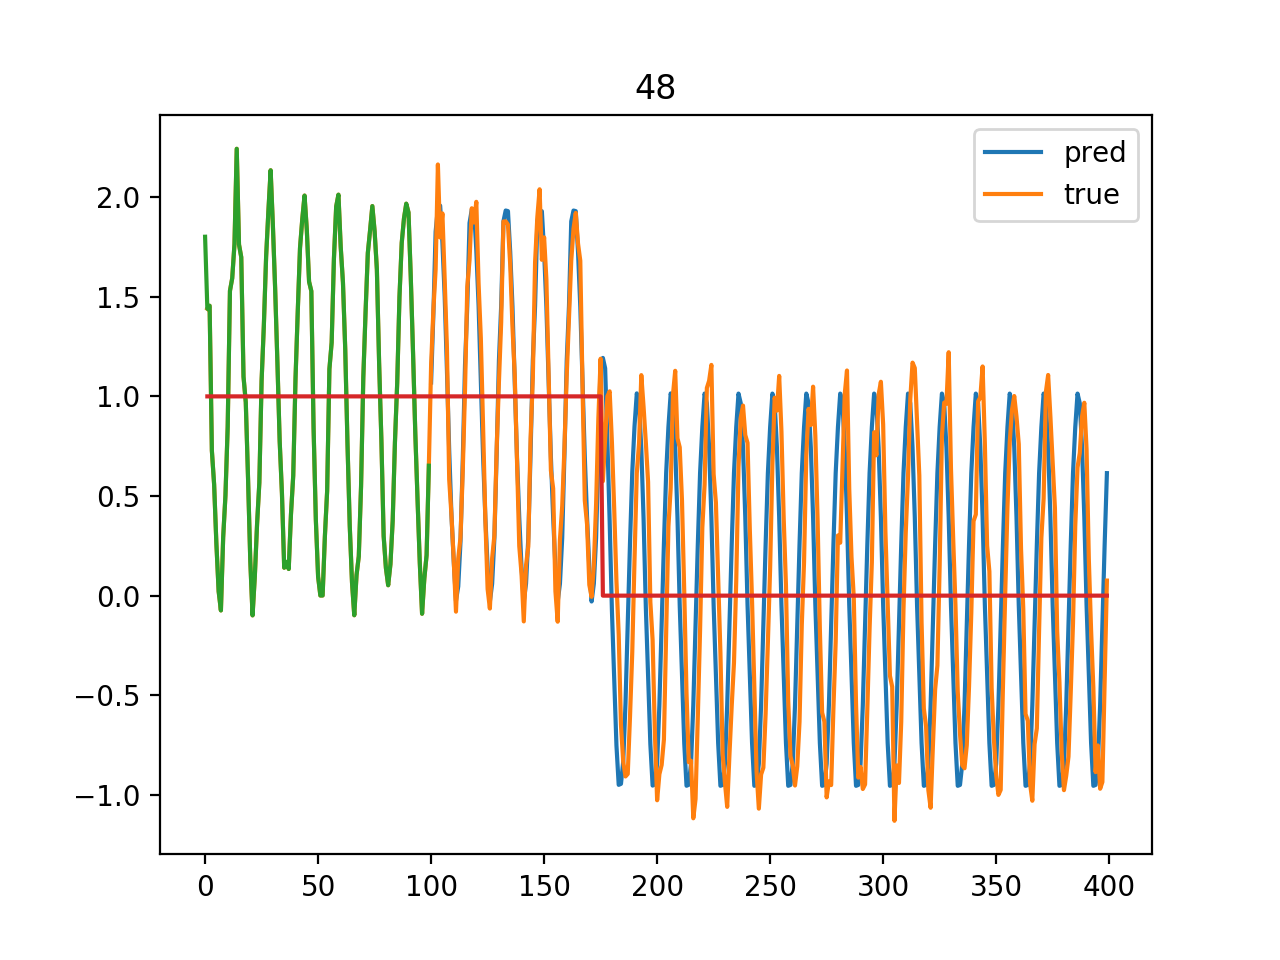

In [423]:
idx = np.random.randint(batch_size)
idx=48
fig, ax = plt.subplots()
ax.plot(np.arange(input_seq_len, input_seq_len + pred_steps), outputs[idx].asnumpy().ravel(), label='pred')
ax.plot(np.arange(1, input_seq_len + pred_steps), c[idx].asnumpy().ravel(), label='true')
ax.plot(np.arange(input_seq_len), a[idx].asnumpy().ravel())
ax.plot(np.arange(1, input_seq_len + pred_steps), b[idx].asnumpy().ravel())
ax.set_title(idx)
ax.legend();